In [120]:
# import packages
from scipy.stats import norm, t
import scipy
import numpy as np
import pandas as pd
import os
from datetime import datetime
from functools import partial
from math import log, sqrt, exp, isclose
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append(r"C:\Users\WANGLIN CAI\fintech545")
import RiskManagement as RM

In [ ]:
# 1.1 Closed form greeks for GBSM

In [121]:
current_date = datetime(2022, 3, 13)
expire_date = datetime(2022, 4, 15)
T = (expire_date - current_date).days / 365

S = 165
X = 165
implied_vol = 0.2

r = 0.0425
coupon = 0.0053
b = r - coupon

In [122]:
def calculate_d1(S, X, T, implied_vol, b):
  return (np.log(S / X) + (b + implied_vol ** 2 / 2) * T) / (implied_vol * np.sqrt(T))

def calculate_d2(d1, T, implied_vol):
  return d1 - implied_vol * np.sqrt(T)

In [123]:
def gbsm_delta(option_type, S, X, T, implied_vol, r, b):
  is_call = 1 if option_type == "Call" else -1
  d1 = calculate_d1(S, X, T, implied_vol, b)
  delta = norm.cdf(d1 * is_call, 0, 1) * is_call
  return delta

def gbsm_gamma(option_type, S, X, T, implied_vol, r, b):
  d1 = calculate_d1(S, X, T, implied_vol, b)
  d2 = calculate_d2(d1, T, implied_vol)
  gamma = norm.pdf(d1, 0, 1) / (S * implied_vol * np.sqrt(T))
  return gamma

def gbsm_vega(option_type, S, X, T, implied_vol, r, b):
  d1 = calculate_d1(S, X, T, implied_vol, b)
  d2 = calculate_d2(d1, T, implied_vol)
  vega = S * norm.pdf(d1, 0, 1) * np.sqrt(T)
  return vega

def gbsm_theta(option_type, S, X, T, implied_vol, r, b):
  is_call = 1 if option_type == "Call" else -1
  d1 = calculate_d1(S, X, T, implied_vol, b)
  d2 = calculate_d2(d1, T, implied_vol)
  theta = -S * np.exp((b - r) * T) * norm.pdf(d1, 0, 1) * implied_vol / (2 * np.sqrt(T)) \
          -(b - r) * S * np.exp((b - r) * T) * norm.cdf(d1 * is_call, 0, 1) * is_call \
          -r * X * np.exp(-r * T) * norm.cdf(d2 * is_call, 0, 1) * is_call
  return theta

def gbsm_rho(option_type, S, X, T, implied_vol, r, b):
  is_call = 1 if option_type == "Call" else -1
  d1 = calculate_d1(S, X, T, implied_vol, b)
  d2 = calculate_d2(d1, T, implied_vol)
  rho = X * T * np.exp(-r * T) * norm.cdf(d2 * is_call, 0, 1) * is_call
  return rho

def gbsm_carry_rho(option_type, S, X, T, implied_vol, r, b):
  is_call = 1 if option_type == "Call" else -1
  d1 = calculate_d1(S, X, T, implied_vol, b)
  d2 = calculate_d2(d1, T, implied_vol)
  carry_rho = S * T * np.exp((b - r) * T) * norm.cdf(d1 * is_call, 0, 1) * is_call
  return carry_rho

In [124]:
# 1.2 Finite difference derivative calculation and comparison.

In [125]:
import inspect

# calculate first order derivative
def first_order_der(func, x, delta):
  return (func(x + delta) - func(x - delta)) / (2 * delta)

# calculate second order derivative
def second_order_der(func, x, delta):
  return (func(x + delta) + func(x - delta) - 2 * func(x)) / delta ** 2

def cal_partial_derivative(func, order, arg_name, delta=1e-3):
  # initialize for argument names and order
  arg_names = list(inspect.signature(func).parameters.keys())
  derivative_fs = {1: first_order_der, 2: second_order_der}

  def partial_derivative(*args, **kwargs):
    # parse argument names and order
    args_dict = dict(list(zip(arg_names, args)) + list(kwargs.items()))
    arg_val = args_dict.pop(arg_name)

    def partial_f(x):
      p_kwargs = {arg_name:x, **args_dict}
      return func(**p_kwargs)
    return derivative_fs[order](partial_f, arg_val, delta)
  return partial_derivative

In [126]:
def gbsm(option_type, S, X, T, implied_vol, r, b):
  d1 = (np.log(S / X) + (b + 0.5 * implied_vol ** 2) * T) / (implied_vol * np.sqrt(T))
  d2 = d1 - implied_vol * np.sqrt(T)
  is_call = 1 if option_type == "Call" else -1

  res = is_call * (S * np.e ** ((b - r) * T) * \
                   scipy.stats.norm(0, 1).cdf(is_call * d1) \
                   - X * np.e ** (-r * T) * \
                   scipy.stats.norm(0, 1).cdf(is_call * d2))
    
  return res

In [127]:
# delta
delta_call = gbsm_delta("Call", S, X, T, implied_vol, r, b)
delta_put = gbsm_delta("Put", S, X, T, implied_vol, r, b)
gbsm_delta_num = cal_partial_derivative(gbsm, 1, 'S')
delta_call_num = gbsm_delta_num("Call", S, X, T, implied_vol, r, b)
delta_put_num = gbsm_delta_num("Put", S, X, T, implied_vol, r, b)
print(delta_call, delta_put)
print(delta_call_num, delta_put_num)

0.5342650692693474 -0.46573493073065264
0.5340091223970944 -0.46551181431908617


In [128]:
# gamma
gamma_call = gbsm_gamma("Call", S, X, T, implied_vol, r, b)
gamma_put = gbsm_gamma("Put", S, X, T, implied_vol, r, b)
gbsm_gamma_num = cal_partial_derivative(gbsm, 2, 'S')
gamma_call_num = gbsm_gamma_num("Call", S, X, T, implied_vol, r, b)
gamma_put_num = gbsm_gamma_num("Put", S, X, T, implied_vol, r, b)
print(gamma_call, gamma_put)
print(gamma_call_num, gamma_put_num)

0.04005712070020568 0.04005712070020568
0.040037932080849714 0.040037960502559145


In [129]:
# vega
vega_call = gbsm_vega("Call", S, X, T, implied_vol, r, b)
vega_put = gbsm_vega("Put", S, X, T, implied_vol, r, b)
gbsm_vega_num = cal_partial_derivative(gbsm, 1, 'implied_vol')
vega_call_num = gbsm_vega_num("Call", S, X, T, implied_vol, r, b)
vega_put_num = gbsm_vega_num("Put", S, X, T, implied_vol, r, b)
print(vega_call, vega_put)
print(vega_call_num, vega_put_num)

19.71962666579851 19.71962666579851
19.71017887198201 19.71017887198201


In [130]:
# theta
theta_call = gbsm_theta("Call", S, X, T, implied_vol, r, b)
theta_put = gbsm_theta("Put", S, X, T, implied_vol, r, b)
gbsm_theta_num = cal_partial_derivative(gbsm, 1, 'T')
theta_call_num = -gbsm_theta_num("Call", S, X, T, implied_vol, r, b)
theta_put_num = -gbsm_theta_num("Put", S, X, T, implied_vol, r, b)
print(theta_call, theta_put)
print(theta_call_num, theta_put_num)

-24.898522316969515 -18.786996965277233
-24.898857359268334 -18.78733200548055


In [131]:
# rho
rho_call = gbsm_rho("Call", S, X, T, implied_vol, r, b)
rho_put = gbsm_rho("Put", S, X, T, implied_vol, r, b)
gbsm_rho_num = cal_partial_derivative(gbsm, 1, 'r')
rho_call_num = gbsm_rho_num("Call", S, X, T, implied_vol, r, b)
rho_put_num = gbsm_rho_num("Put", S, X, T, implied_vol, r, b)
print(rho_call, rho_put)
print(rho_call_num, rho_put_num)

7.583586080244792 -7.277010958127815
-0.3826595967950652 -0.3325949902830416


In [132]:
# carry rho
carry_rho_call = gbsm_carry_rho("Call", S, X, T, implied_vol, r, b)
carry_rho_put = gbsm_carry_rho("Put", S, X, T, implied_vol, r, b)
gbsm_carry_rho_num = cal_partial_derivative(gbsm, 1, 'b')
carry_rho_call_num = gbsm_carry_rho_num("Call", S, X, T, implied_vol, r, b)
carry_rho_put_num = gbsm_carry_rho_num("Put", S, X, T, implied_vol, r, b)
print(carry_rho_call, carry_rho_put)
print(carry_rho_call_num, carry_rho_put_num)

7.966245676523029 -6.944415968299725
7.96624576389604 -6.944415901223522


In [133]:
def n_nodes(N):
    return (N + 2) * (N + 1) // 2

def node_index(i, j):
    return n_nodes(j - 1) + i

def binomial_tree_no_div(option_type, S0, X, T, implied_vol, r, N):
  is_call = 1 if option_type == "Call" else -1
  dt = T / N
  disc = np.exp(-r * dt)
  u = np.exp(implied_vol * np.sqrt(dt))
  d = 1 / u
  p = (np.exp(r * dt) - d) / (u - d)
    
  C = np.empty(n_nodes(N), dtype=float)
            
  for i in np.arange(N, -1, -1):
    for j in range(i, -1, -1):
      S = S0 * u ** j * d ** (i - j)
      index = node_index(j, i)
      C[index] = max(0, (S - X) * is_call)
      if i < N:
        val = disc * (p * C[node_index(j + 1, i + 1)] + (1 - p) * C[node_index(j, i + 1)])
        C[index] = max(C[index], val)
                
  return C[0]

def binomial_tree(option_type, S0, X, T, div_time, div, implied_vol, r, N):
  if div_time is None or div is None:
    return binomial_tree_no_div(option_type, S0, X, T, implied_vol, r, N)
  
  is_call = 1 if option_type == "Call" else -1
  dt = T / N
  disc = np.exp(-r * dt)
    
  #calculate u, d, and p
  u = np.exp(implied_vol * np.sqrt(dt))
  d = 1 / u
  p = (np.exp(r * dt) - d) / (u - d)

  new_T = T - div_time * dt
  new_N = N - div_time

  C = np.empty(n_nodes(div_time), dtype=float)
  for i in range(div_time, -1, -1):
    for j in range(i, -1, -1):
      S = S0 * u ** j * d ** (i - j)
      val_exe = max(0, (S - X) * is_call)
      if i < div_time:
        val = disc * (p * C[node_index(j + 1, i + 1)] + (1 - p) * C[node_index(j, i + 1)])
      else:
        val = binomial_tree(option_type, S - div, X, new_T, None, None, implied_vol, r, new_N)
      C[node_index(j, i)] = max(val_exe, val)
    
  return C[0]

In [134]:
# 1.4 Calculate the value of the call and the put. Calculate the Greeks of each.

In [135]:
# Assume N is 300
N = 300
value_no_div_call = binomial_tree_no_div("Call", S, X, T, implied_vol, r, N)
value_no_div_put = binomial_tree_no_div("Put", S, X, T, implied_vol, r, N)
print("Binomial tree value without dividend for call: " + str(value_no_div_call))
print("Binomial tree value without dividend for put: " + str(value_no_div_put))
     

Binomial tree value without dividend for call: 4.271506155124947
Binomial tree value without dividend for put: 3.685242343269967


In [136]:
div_date = datetime(2022, 4, 11)
div = 0.88
div_time = int((div_date - current_date).days / (expire_date - current_date).days * N)

value_call = binomial_tree("Call", S, X, T, div_time, div, implied_vol, r, N)
value_put = binomial_tree("Put", S, X, T, div_time, div, implied_vol, r, N)
print("Binomial tree value with dividend for call: " + str(value_call))
print("Binomial tree value with dividend for put: " + str(value_put))

Binomial tree value with dividend for call: 4.1140138117912395
Binomial tree value with dividend for put: 4.107373800666709


In [137]:
# delta
cal_amr_delta_num = cal_partial_derivative(binomial_tree, 1, 'S0')
delta_call_amr = cal_amr_delta_num("Call", S, X, T, div_time, div, implied_vol, r, N)
delta_put_amr = cal_amr_delta_num("Put", S, X, T, div_time, div, implied_vol, r, N)
print(delta_call_amr, delta_put_amr)

0.5404928437804379 -0.4888376347138568


In [138]:
# gamma
cal_amr_gamma_num = cal_partial_derivative(binomial_tree, 2, 'S0', delta=1)
gamma_call_amr = cal_amr_gamma_num("Call", S, X, T, div_time, div, implied_vol, r, N)
gamma_put_amr = cal_amr_gamma_num("Put", S, X, T, div_time, div, implied_vol, r, N)
print(gamma_call_amr, gamma_put_amr)

0.04041911053184144 0.0395121232373139


In [139]:
# vega
cal_amr_vega_num = cal_partial_derivative(binomial_tree, 1, 'implied_vol')
vega_call_amr = cal_amr_vega_num("Call", S, X, T, div_time, div, implied_vol, r, N)
vega_put_amr = cal_amr_vega_num("Put", S, X, T, div_time, div, implied_vol, r, N)
print(vega_call_amr, vega_put_amr)

19.531465248245006 19.827352392823183


In [140]:
# theta
cal_amr_theta_num = cal_partial_derivative(binomial_tree, 1, 'T')
theta_call_amr = -cal_amr_theta_num("Call", S, X, T, div_time, div, implied_vol, r, N)
theta_put_amr = -cal_amr_theta_num("Put", S, X, T, div_time, div, implied_vol, r, N)
print(theta_call_amr, theta_put_amr)

-24.808805697263736 -18.542829430221897


In [141]:
# rho
cal_amr_rho_num = cal_partial_derivative(binomial_tree, 1, 'r')
rho_call_amr = cal_amr_rho_num("Call", S, X, T, div_time, div, implied_vol, r, N)
rho_put_amr = cal_amr_rho_num("Put", S, X, T, div_time, div, implied_vol, r, N)
print(rho_call_amr, rho_put_amr)

6.819090304833075 -7.207250065234927


In [142]:
# 1.5 What is the sensitivity of the put and call to a change in the dividend amount?

In [143]:
# sensitivity to change in dividend amount
# change the dividend amount on the first ex-dividend date by 1e-3
delta = 1e-3
call_value1 = binomial_tree("Call", S, X, T, div_time, div + delta, implied_vol, r, N)    
call_value2 = binomial_tree("Call", S, X, T, div_time, div - delta, implied_vol, r, N)    
call_sens_to_div_amount = (call_value1 - call_value2) / (2*delta)

put_value1 = binomial_tree("Put", S, X, T, div_time, div + delta, implied_vol, r, N)    
put_value2 = binomial_tree("Put", S, X, T, div_time, div - delta, implied_vol, r, N)    
put_sens_to_div_amount = (put_value1 - put_value2) / (2*delta)
print(f"Sensitivity to dividend amount: Call: {call_sens_to_div_amount:.3f}, Put: {put_sens_to_div_amount:.3f}")

Sensitivity to dividend amount: Call: -0.104, Put: 0.508


In [ ]:
# problem 2

In [22]:
def implied_vol_american(option_type, S0, X, T, div_time, div, r, N, market_price, x0=0.5):
  def equation(implied_vol):
    return binomial_tree(option_type, S0, X, T, div_time, div, implied_vol, r, N) - market_price
  # Back solve the binomial tree valuation to get the implied volatility
  return scipy.optimize.fsolve(equation, x0=x0, xtol=0.00001)[0]

def calculate_sim_values(portfolios, sim_prices, days_ahead=0):
  sim_values = pd.DataFrame(index=portfolios.index, 
                            columns=list(range(sim_prices.shape[0])))
  sim_prices = np.array(sim_prices)
  for i in portfolios.index:
    if portfolios["Type"][i] == "Stock":
      # For stock, the single value is its price
      single_values = sim_prices
    else:
      # For option, calculate values with gbsm method
      option_type = portfolios["OptionType"][i]
      X = portfolios["Strike"][i]
      T = ((portfolios["ExpirationDate"][i] - current_date).days - days_ahead) / 365
      implied_vol = portfolios["ImpliedVol"][i]
      div_time = int((div_date - current_date).days / (portfolios["ExpirationDate"][i] - current_date).days * N)
      div = 1
      option_values = []
      for S in sim_prices:
        option_values.append(binomial_tree(option_type, S, X, T, div_time, div, implied_vol, r, N))
      single_values = np.array(option_values)
    
    # Calculate the total values based on holding
    sim_values.loc[i, :] = portfolios["Holding"][i] * single_values
  
  # Combine the values for same portfolios
  sim_values['Portfolio'] = portfolios['Portfolio']
  return sim_values.groupby('Portfolio').sum()

In [23]:
portfolios = pd.read_csv('problem2.csv', parse_dates=['ExpirationDate'])
portfolios['CurrentValue'] = portfolios['CurrentPrice'] * portfolios['Holding']

S = 151.03
N = 25
current_date = datetime(2023, 3, 3)
div_date = datetime(2023, 3, 15)
r = 0.0425
div = 1

# Calculate the implied volatility for all portfolios
implied_vols = []
for i in range(len(portfolios.index)):
  if portfolios["Type"][i] == "Stock":
    implied_vols.append(None)
  else:
    option_type = portfolios["OptionType"][i]
    X = portfolios["Strike"][i]
    T = (portfolios["ExpirationDate"][i] - current_date).days / 365
    div_time = int((div_date - current_date).days / (portfolios["ExpirationDate"][i] - current_date).days * N)
    market_price = portfolios["CurrentPrice"][i]
    implied_vol = implied_vol_american(option_type, S, X, T, div_time, div, r, N, market_price)
    implied_vols.append(implied_vol)

# Store the implied volatility in portfolios
portfolios["ImpliedVol"] = implied_vols

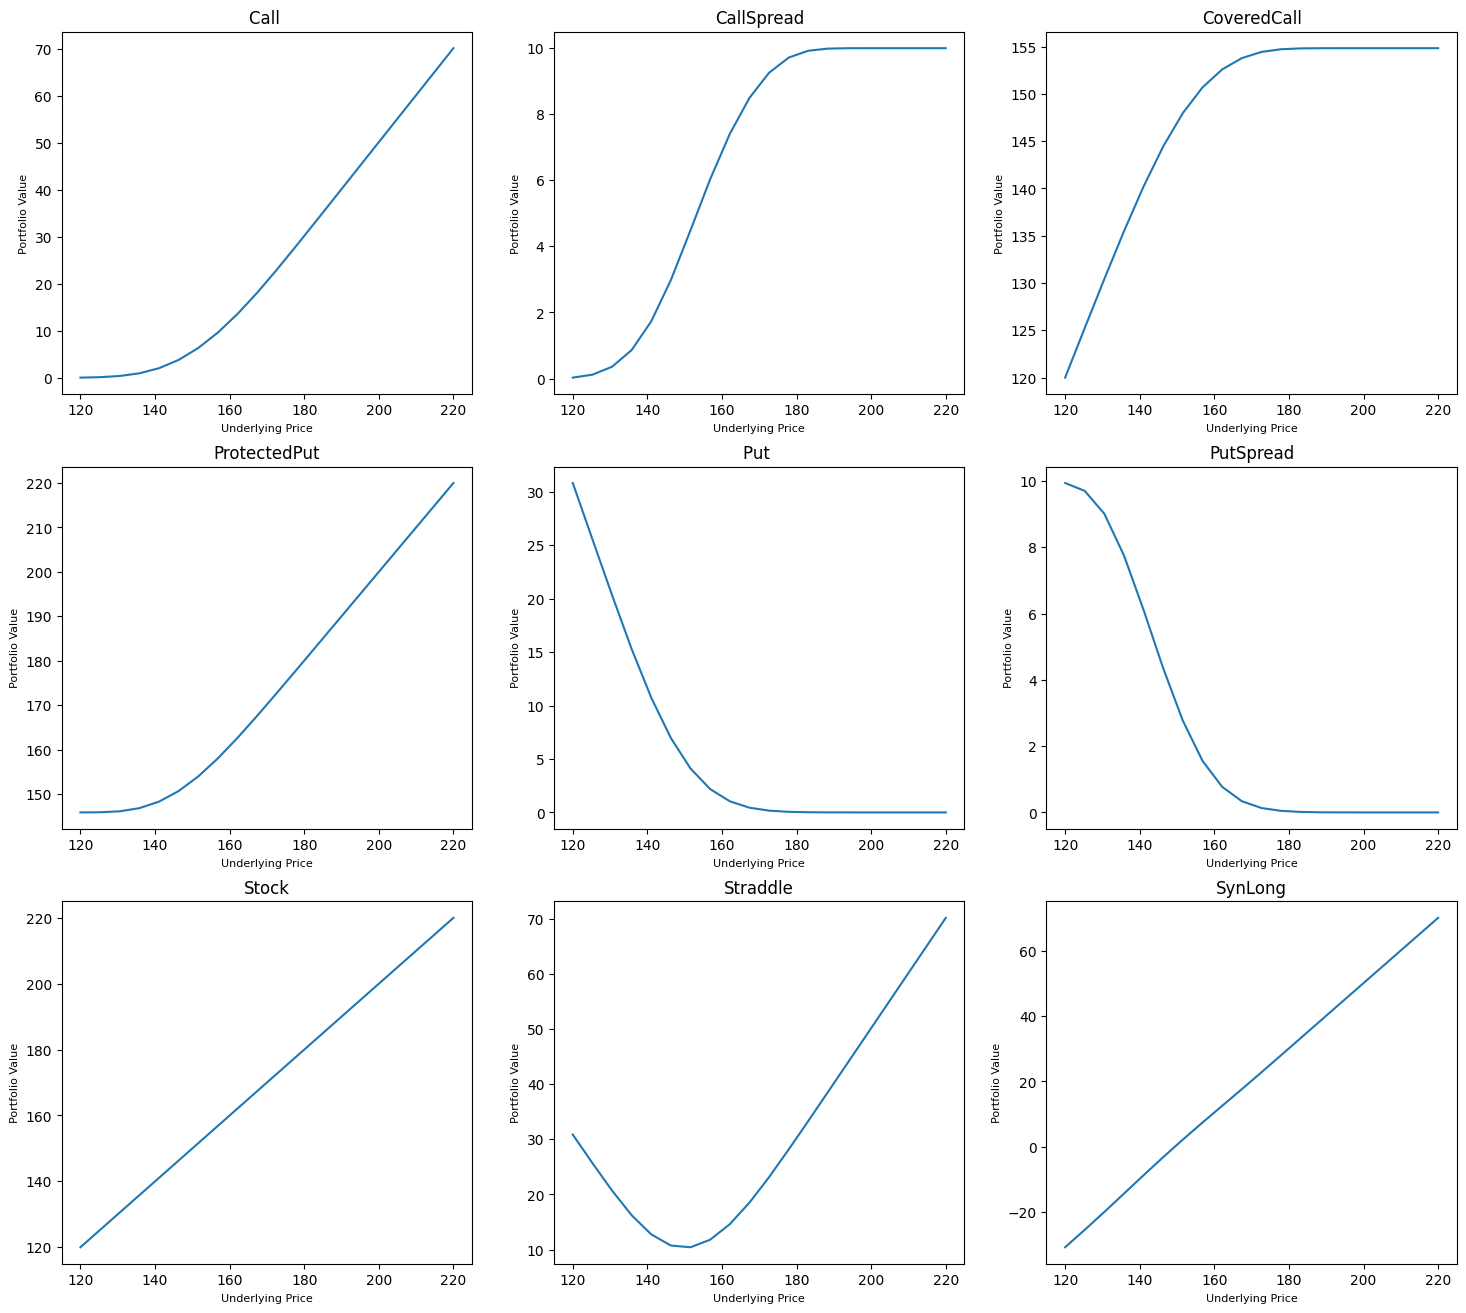

In [24]:
# Simulate the price in 120-220 range
sim_prices = np.linspace(120, 220, 20)

# Calculate the stock and option values
sim_values = calculate_sim_values(portfolios, sim_prices, 10)

# Plot the values for each portfolio
fig, axes = plt.subplots(3, 3, figsize=(18, 16))
idx = 0
for portfolio, dataframe in sim_values.groupby('Portfolio'):
  i, j = idx // 3, idx % 3
  ax = axes[i][j]
  ax.plot(sim_prices, dataframe.iloc[0, :].values)
  ax.set_title(portfolio)
  ax.set_xlabel('Underlying Price', fontsize=8)
  ax.set_ylabel('Portfolio Value', fontsize=8)
  idx += 1

In [ ]:
# 2.2 Fit a Normal distribution and calculate Mean, VaR and ES.


In [26]:
S = 151.03
N = 25
current_date = datetime(2023, 3, 3)
div_date = datetime(2023, 3, 15)
r = 0.0425
div = 1
all_prices = pd.read_csv("DailyPrices.csv")
all_returns = RM.return_calculate(all_prices, method= "LOG", dateColumn="Date")



In [27]:
all_returns

,Date,SPY,AAPL,MSFT,AMZN,TSLA,GOOGL,GOOG,META,NVDA,...,PNC,MDLZ,MO,ADI,GILD,LMT,SYK,GM,TFC,TJX
1,2/15/2022 0:00,0.015998,0.022888,0.018372,0.008621,0.051919,0.007956,0.008284,0.015045,0.087839,...,0.012726,-0.004091,0.004581,0.051021,0.003594,-0.012351,0.032487,0.025901,0.028171,0.013150
2,2/16/2022 0:00,0.001120,-0.001390,-0.001168,0.010108,0.001040,0.008234,0.007754,-0.020387,0.000604,...,0.006734,-0.002432,0.005747,0.038143,0.009251,0.012170,0.003357,0.015185,-0.001390,-0.026327
3,2/17/2022 0:00,-0.021593,-0.021499,-0.029719,-0.022050,-0.052286,-0.038476,-0.038397,-0.041632,-0.078601,...,-0.035574,0.005312,0.014905,-0.048128,-0.009903,0.004822,-0.031343,-0.032446,-0.033950,-0.029185
4,2/18/2022 0:00,-0.006496,-0.009400,-0.009678,-0.013351,-0.022351,-0.016247,-0.014012,-0.007490,-0.035934,...,-0.000646,-0.000909,0.007177,-0.000436,-0.003924,-0.005960,-0.013768,-0.004517,-0.003684,0.014926
5,2/22/2022 0:00,-0.010790,-0.017973,-0.000729,-0.015879,-0.042246,-0.004531,-0.008196,-0.019989,-0.010716,...,0.009450,0.007096,-0.008930,0.003238,-0.001147,-0.000673,0.008308,-0.038382,-0.002249,-0.013699
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2/3/2023 0:00,-0.010686,0.024107,-0.023904,-0.088083,0.009042,-0.027858,-0.033458,-0.011937,-0.028454,...,-0.004705,-0.011315,-0.001278,-0.002681,0.037499,0.004125,0.002334,-0.008956,-0.005971,0.001616
245,2/6/2023 0:00,-0.006130,-0.018091,-0.006135,-0.011772,0.024849,-0.018105,-0.016772,-0.002523,-0.000521,...,-0.014556,0.003937,0.001065,-0.007127,0.021773,0.021592,-0.042053,0.005093,-0.009831,-0.004606
246,2/7/2023 0:00,0.012994,0.019062,0.041163,-0.000685,0.010471,0.045035,0.043220,0.029445,0.050124,...,-0.000368,-0.016610,-0.008554,0.019355,-0.003596,-0.001643,0.003567,0.001450,0.008632,-0.003625
247,2/8/2023 0:00,-0.010995,-0.017810,-0.003107,-0.020381,0.022508,-0.079942,-0.077331,-0.043681,0.001442,...,-0.008505,-0.004466,-0.001290,-0.018173,-0.004426,0.002815,-0.015648,0.004098,-0.015510,0.009320


In [28]:
# Simulate the prices based on returns with normal distribution
std = all_returns['AAPL'].std()
np.random.seed(0)
sim_returns = scipy.stats.norm(0, std).rvs((10, 100))
sim_prices = 151.03 * (1 + sim_returns).prod(axis=0)

# Calculate the current values and sim values
portfolios["CurrentValue"] = portfolios["CurrentPrice"] * portfolios["Holding"]
curr_values = portfolios.groupby('Portfolio')['CurrentValue'].sum()
sim_values = calculate_sim_values(portfolios, sim_prices, 10)

# Calculate the value difference
sim_value_changes = (sim_values.T - curr_values).T


In [45]:
curr_values

Portfolio
Call              6.80
CallSpread        4.59
CoveredCall     146.98
ProtectedPut    154.04
Put               4.85
PutSpread         3.01
Stock           151.03
Straddle         11.65
SynLong           1.95
Name: CurrentValue, dtype: float64

In [35]:
sim_values

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
Portfolio,,,,,,,,,,,,,,,,,,,,,
Call,3.696995,3.721341,8.086201,17.287494,3.883030,11.021917,4.405491,0.183748,10.295121,13.419215,...,2.109571,11.361710,7.145355,1.899976,7.621929,15.303460,4.673890,6.344092,11.493016,10.742245
CallSpread,2.923976,2.939718,5.342283,8.301017,3.044266,6.597863,3.382089,0.177535,6.335391,7.345453,...,1.796357,6.675107,4.940570,1.643539,5.134709,7.919932,3.572299,4.497882,6.704956,6.533327
CoveredCall,144.273758,144.322229,149.667953,153.636933,144.644146,151.588958,145.684345,127.585147,151.135266,152.528589,...,140.533026,151.739822,148.920927,139.780573,149.357540,153.212846,146.084088,148.002213,151.798120,151.430309
ProtectedPut,150.518726,150.552936,156.201637,166.739658,150.780140,159.688161,151.516136,145.948577,158.796534,162.448407,...,148.399110,160.127489,154.989331,148.075257,155.654871,164.528137,151.840416,153.965387,160.297398,159.328031
Put,7.103832,7.063735,2.875651,0.527067,6.798004,1.644711,5.942518,23.218907,1.884691,1.076594,...,10.456742,1.553586,3.402259,11.137172,3.087525,0.751804,5.582785,4.089576,1.518480,1.721011
PutSpread,4.419738,4.399541,2.028963,0.408892,4.265959,1.209720,3.836515,9.445319,1.348396,0.799188,...,5.989875,1.161271,2.340818,6.266197,2.173371,0.574601,3.655979,2.752666,1.135174,1.247038
Stock,146.074367,146.138250,154.624186,166.492574,146.562522,158.852543,147.933455,127.624182,157.810378,161.910833,...,141.406400,159.339777,153.097163,140.536992,153.951475,164.178720,148.511943,151.612233,159.528058,158.451517
Straddle,10.800827,10.785076,10.961852,17.814561,10.681034,12.666629,10.348009,23.402655,12.179812,14.495809,...,12.566313,12.915297,10.547614,13.037148,10.709454,16.055264,10.256676,10.433668,13.011496,12.463256
SynLong,-3.406837,-3.342395,5.210549,16.760427,-2.914974,9.377206,-1.537027,-23.035159,8.410430,12.342621,...,-8.347172,9.808124,3.743096,-9.237195,4.534404,14.551655,-0.908895,2.254516,9.974537,9.021234


In [46]:
# Calculate the Mean, VaR and ES, and print the results
resulting_mat = pd.DataFrame(0, index=sim_values.index.values, columns=["Mean", "VaR($)", "ES($)"])
for i in range(len(resulting_mat)):
    resulting_mat.iloc[i,0] = sim_values.iloc[i,:].mean()
    resulting_mat.iloc[i,1], resulting_mat.iloc[i,2] = RM.cal_VaR_ES_hist(sim_value_changes.iloc[i,:],alpha=0.05)[0:2]

In [47]:
resulting_mat

,Mean,VaR($),ES($)
Call,6.672356,6.192209,6.562053
CallSpread,4.064176,4.022207,4.361915
CoveredCall,145.248033,13.841819,18.791813
ProtectedPut,154.082517,7.642252,8.040817
Put,6.802323,4.351499,4.649564
PutSpread,3.828268,2.624612,2.853856
Stock,149.520044,17.729656,22.788306
Straddle,13.474678,1.346927,1.385833
SynLong,-0.129967,18.995445,24.324425


In [ ]:
# 2.3 Calculate VaR and ES using Delta-Normal.

In [49]:
S = 151.03
N = 25
current_date = datetime(2023, 3, 3)
div_date = datetime(2023, 3, 15)
r = 0.0425
div = 1

cal_amr_delta_num =  cal_partial_derivative(binomial_tree, 1, 'S0')

In [50]:
# Calculate the implied volatility for all portfolios
deltas = []
for i in range(len(portfolios.index)):
  if portfolios["Type"][i] == "Stock":
    deltas.append(1)
  else:
    option_type = portfolios["OptionType"][i]
    X = portfolios["Strike"][i]
    T = ((portfolios["ExpirationDate"][i] - current_date).days - 10) / 365
    div_time = int((div_date - current_date).days / (portfolios["ExpirationDate"][i] - current_date).days * N)
    delta = cal_amr_delta_num(option_type, S, X, T, div_time, div, implied_vol, r, N)
    deltas.append(delta)

In [144]:
deltas

[0.540068567444596,
 -0.4644847553265663,
 0.540068567444596,
 -0.4644847553265663,
 0.540068567444596,
 0.24144707643669605,
 -0.4644847553265663,
 -0.18554087454214496,
 1,
 0.540068567444596,
 -0.4644847553265663,
 1,
 0.3815521521051135,
 1,
 -0.31121246555421145]

In [51]:
# Store the deltas in portfolios
portfolios["deltas"] = deltas

alpha = 0.05
t = 10
result_dn = pd.DataFrame(index=sorted(portfolios['Portfolio'].unique()), columns=['Mean', 'VaR', 'ES'])
result_dn.index.name = 'Portfolio'
for pfl, df in portfolios.groupby('Portfolio'):
  gradient = S / df['CurrentValue'].sum() * (df['Holding'] * df['deltas']).sum()
  pfl_10d_std = abs(gradient) * std * np.sqrt(t)
  N = scipy.stats.norm(0, 1)
  present_value = df['CurrentValue'].sum() 
  result_dn.loc[pfl]['Mean'] = 0
  result_dn.loc[pfl]['VaR'] = -present_value * N.ppf(alpha) * pfl_10d_std
  result_dn.loc[pfl]['ES'] = present_value * pfl_10d_std * N.pdf(N.ppf(alpha)) / alpha

result_dn

,Mean,VaR,ES
Portfolio,,,
Call,0,9.514631,11.931731
CallSpread,0,5.260949,6.597442
CoveredCall,0,10.895474,13.663364
ProtectedPut,0,12.13468,15.217378
Put,0,8.183037,10.261858
PutSpread,0,4.91428,6.162705
Stock,0,17.61745,22.092993
Straddle,0,1.331594,1.669873
SynLong,0,17.697668,22.193589


In [ ]:
# Problem 3

In [58]:
# data preparation
ff = pd.read_csv('F-F_Research_Data_Factors_daily.csv', parse_dates=['Date']).set_index('Date')
mom = pd.read_csv('F-F_Momentum_Factor_daily.csv', parse_dates=['Date']).set_index('Date')
# transfer percentage to value
data = ff.join(mom, how='right') / 100

In [94]:
data

,Mkt-RF,SMB,HML,RF,Mom
Date,,,,,
1926-11-03,0.0020,-0.0020,-0.0033,0.00013,0.0056
1926-11-04,0.0059,-0.0012,0.0065,0.00013,-0.0050
1926-11-05,0.0007,-0.0011,0.0026,0.00013,0.0117
1926-11-06,0.0016,-0.0029,0.0005,0.00013,-0.0003
1926-11-08,0.0052,-0.0012,0.0018,0.00013,-0.0001
...,...,...,...,...,...
2023-01-25,0.0000,-0.0004,0.0065,0.00017,0.0014
2023-01-26,0.0108,-0.0058,0.0001,0.00017,-0.0123
2023-01-27,0.0036,0.0062,-0.0116,0.00017,-0.0246


In [66]:
all_prices = pd.read_csv("DailyPrices.csv", parse_dates=["Date"])
all_returns = RM.return_calculate(all_prices, method= "LOG", dateColumn="Date")

In [84]:
all_returns = all_returns.set_index("Date")

In [100]:

stocks = ['AAPL', 'META', 'UNH', 'MA',  
          'MSFT' ,'NVDA', 'HD', 'PFE',  
          'AMZN' ,'BRK-B', 'PG', 'XOM',  
          'TSLA' ,'JPM' ,'V', 'DIS',  
          'GOOGL', 'JNJ', 'BAC', 'CSCO']
factors = ['Mkt-RF', 'SMB', 'HML', 'RF']
dataset = all_returns[stocks].join(data)

In [105]:
dataset

,AAPL,META,UNH,MA,MSFT,NVDA,HD,PFE,AMZN,BRK-B,...,DIS,GOOGL,JNJ,BAC,CSCO,Mkt-RF,SMB,HML,RF,Mom
Date,,,,,,,,,,,,,,,,,,,,,
2022-02-15,0.022888,0.015045,0.008041,0.019532,0.018372,0.087839,0.004824,-0.000201,0.008621,0.006091,...,0.025331,0.007956,0.010273,0.007772,0.020289,0.0187,0.0133,-0.0142,0.0,-0.0091
2022-02-16,-0.001390,-0.020387,0.003798,0.003636,-0.001168,0.000604,-0.009014,-0.002212,0.010108,-0.001741,...,0.010480,0.008234,-0.000598,-0.002304,-0.000369,-0.0002,-0.0009,0.0031,0.0,0.0064
2022-02-17,-0.021499,-0.041632,-0.020434,-0.024399,-0.029719,-0.078601,-0.006160,-0.015825,-0.022050,-0.006675,...,-0.021986,-0.038476,-0.006119,-0.034350,0.027633,-0.0228,-0.0028,0.0110,0.0,0.0103
2022-02-18,-0.009400,-0.007490,-0.005394,-0.010086,-0.009678,-0.035934,-0.003080,-0.007595,-0.013351,0.003979,...,-0.010450,-0.016247,-0.010777,-0.002391,0.025493,-0.0087,-0.0009,0.0093,0.0,0.0104
2022-02-22,-0.017973,-0.019989,-0.011394,-0.004497,-0.000729,-0.010716,-0.092670,-0.020821,-0.015879,-0.002035,...,-0.021841,-0.004531,-0.013683,-0.008741,-0.016034,-0.0118,-0.0048,0.0011,0.0,0.0043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-03,0.024107,-0.011937,0.002524,-0.002751,-0.023904,-0.028454,-0.024700,-0.006335,-0.088083,-0.010800,...,-0.022330,-0.027858,-0.005634,0.008269,-0.014089,NaN,NaN,NaN,NaN,NaN
2023-02-06,-0.018091,-0.002523,0.006799,-0.002517,-0.006135,-0.000521,-0.006750,-0.006832,-0.011772,-0.000259,...,-0.007616,-0.018105,-0.007623,-0.001648,-0.022038,NaN,NaN,NaN,NaN,NaN
2023-02-07,0.019062,0.029445,0.003445,0.005588,0.041163,0.050124,-0.012438,-0.003892,-0.000685,0.014612,...,0.015892,0.045035,0.000245,0.010938,0.005660,NaN,NaN,NaN,NaN,NaN


In [109]:
dataset = dataset.drop(dataset['2023-02'].index)

In [110]:
# calculate arithmetic E(r) in past 10 years
avg_factor_rets = data.loc['2013-1-31':'2023-1-31'].mean(axis=0)

In [145]:
dataset

,AAPL,META,UNH,MA,MSFT,NVDA,HD,PFE,AMZN,BRK-B,...,DIS,GOOGL,JNJ,BAC,CSCO,Mkt-RF,SMB,HML,RF,Mom
Date,,,,,,,,,,,,,,,,,,,,,
2022-02-15,0.022888,0.015045,0.008041,0.019532,0.018372,0.087839,0.004824,-0.000201,0.008621,0.006091,...,0.025331,0.007956,0.010273,0.007772,0.020289,0.0187,0.0133,-0.0142,0.00000,-0.0091
2022-02-16,-0.001390,-0.020387,0.003798,0.003636,-0.001168,0.000604,-0.009014,-0.002212,0.010108,-0.001741,...,0.010480,0.008234,-0.000598,-0.002304,-0.000369,-0.0002,-0.0009,0.0031,0.00000,0.0064
2022-02-17,-0.021499,-0.041632,-0.020434,-0.024399,-0.029719,-0.078601,-0.006160,-0.015825,-0.022050,-0.006675,...,-0.021986,-0.038476,-0.006119,-0.034350,0.027633,-0.0228,-0.0028,0.0110,0.00000,0.0103
2022-02-18,-0.009400,-0.007490,-0.005394,-0.010086,-0.009678,-0.035934,-0.003080,-0.007595,-0.013351,0.003979,...,-0.010450,-0.016247,-0.010777,-0.002391,0.025493,-0.0087,-0.0009,0.0093,0.00000,0.0104
2022-02-22,-0.017973,-0.019989,-0.011394,-0.004497,-0.000729,-0.010716,-0.092670,-0.020821,-0.015879,-0.002035,...,-0.021841,-0.004531,-0.013683,-0.008741,-0.016034,-0.0118,-0.0048,0.0011,0.00000,0.0043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-25,-0.004712,-0.011523,0.001829,0.006243,-0.005926,0.003006,-0.001354,0.008020,0.008889,0.001926,...,0.019803,-0.025712,0.007104,0.008641,0.003549,0.0000,-0.0004,0.0065,0.00017,0.0014
2023-01-26,0.014695,0.040172,-0.000041,-0.013560,0.030251,0.024487,-0.010934,-0.009223,0.020775,-0.003050,...,0.014508,0.023867,-0.003664,0.013389,0.007475,0.0108,-0.0058,0.0001,0.00017,-0.0123
2023-01-27,0.013591,0.029697,-0.013142,-0.008546,0.000645,0.028035,0.009136,-0.010450,0.029983,-0.005741,...,-0.001460,0.018793,-0.003916,0.003108,0.003511,0.0036,0.0062,-0.0116,0.00017,-0.0246


In [146]:
avg_daily_rets = pd.Series()
for stock in stocks:
  # calculate betas
  model = sm.OLS(dataset[stock] - dataset['RF'], sm.add_constant(dataset[factors]))
  results = model.fit()
    
  # assume alpha = 0
  avg_daily_rets[stock] = (results.params[factors] * avg_factor_rets[factors]).sum() \
                          + avg_factor_rets['RF'] 

In [147]:
# geometric annual returns: mean and covariance
geo_means = np.log(1 + avg_daily_rets) * 255  
geo_covariance = np.log(1 + all_returns[stocks]).cov() * 255
print(geo_means)

AAPL     0.094815
META     0.364139
UNH     -0.067104
MA       0.196962
MSFT     0.112007
NVDA     0.477393
HD       0.202864
PFE     -0.028339
AMZN     0.160461
BRK-B    0.111659
PG       0.115485
XOM      0.050076
TSLA    -0.115382
JPM      0.304899
V        0.194757
DIS      0.304078
GOOGL    0.153048
JNJ     -0.053340
BAC      0.270332
CSCO     0.197534
dtype: float64


In [148]:
display(geo_covariance)

,AAPL,META,UNH,MA,MSFT,NVDA,HD,PFE,AMZN,BRK-B,PG,XOM,TSLA,JPM,V,DIS,GOOGL,JNJ,BAC,CSCO
AAPL,0.128420,0.141767,0.038210,0.082102,0.103863,0.172784,0.067124,0.033264,0.124313,0.055957,0.037377,0.038211,0.159622,0.058778,0.072251,0.089545,0.112908,0.023170,0.066545,0.067601
META,0.141767,0.432568,0.019368,0.102816,0.142734,0.237412,0.096745,0.046574,0.197253,0.062079,0.033342,0.022000,0.174324,0.074273,0.085601,0.127324,0.182912,0.021635,0.089046,0.076115
UNH,0.038210,0.019368,0.061663,0.031739,0.037093,0.047934,0.026776,0.032249,0.036749,0.028494,0.028296,0.027016,0.040789,0.033466,0.030224,0.023519,0.030250,0.023078,0.034686,0.028918
MA,0.082102,0.102816,0.031739,0.097118,0.080303,0.138967,0.057322,0.034195,0.098782,0.048143,0.031232,0.031746,0.100198,0.058897,0.083473,0.079138,0.079717,0.017602,0.064276,0.052413
MSFT,0.103863,0.142734,0.037093,0.080303,0.129307,0.177341,0.071646,0.035847,0.136562,0.053091,0.034098,0.031595,0.133427,0.056915,0.068638,0.089340,0.121516,0.020631,0.065558,0.061536
NVDA,0.172784,0.237412,0.047934,0.138967,0.177341,0.407973,0.112821,0.047719,0.225900,0.085444,0.041971,0.057013,0.299003,0.099061,0.119867,0.161030,0.188639,0.022461,0.114942,0.098911
HD,0.067124,0.096745,0.026776,0.057322,0.071646,0.112821,0.100060,0.034232,0.098874,0.042729,0.035081,0.015990,0.079521,0.044064,0.050735,0.065139,0.070063,0.022924,0.047222,0.049247
PFE,0.033264,0.046574,0.032249,0.034195,0.035847,0.047719,0.034232,0.071127,0.039182,0.031562,0.027795,0.020266,0.023446,0.032162,0.031222,0.025470,0.029762,0.027893,0.031251,0.029735
AMZN,0.124313,0.197253,0.036749,0.098782,0.136562,0.225900,0.098874,0.039182,0.251933,0.067084,0.031346,0.038389,0.190833,0.072108,0.085893,0.127926,0.152397,0.023550,0.086893,0.073439
BRK-B,0.055957,0.062079,0.028494,0.048143,0.053091,0.085444,0.042729,0.031562,0.067084,0.050435,0.025046,0.034178,0.063062,0.047173,0.042603,0.052099,0.056737,0.019375,0.050972,0.040962


In [115]:
# arithmetic annual returns: mean and covariance
arith_means = np.exp(geo_means + np.diagonal(geo_covariance.values) / 2) - 1

nstocks = geo_covariance.shape[0]
arith_covariance = np.empty((nstocks, nstocks), dtype=float)
for i in range(nstocks):
  for j in range(i, nstocks):
    mu_i, mu_j = geo_means.iloc[i], geo_means.iloc[j]
    sigma2_i, sigma2_j = geo_covariance.iloc[i, i], geo_covariance.iloc[j, j]
    sigma_ij = geo_covariance.iloc[i, j]
    arith_covariance[i, j] = np.exp(mu_i + mu_j + (sigma2_i + sigma2_j) / 2) * (np.exp(sigma_ij) - 1)
    arith_covariance[j, i] = arith_covariance[i, j]
arith_covariance = pd.DataFrame(arith_covariance, columns=stocks, index=stocks)

print(arith_means)

AAPL     0.172367
META     0.786795
UNH     -0.035623
MA       0.278287
MSFT     0.193225
NVDA     0.976604
HD       0.287746
PFE      0.007251
AMZN     0.331662
BRK-B    0.146686
PG       0.150760
XOM      0.118150
TSLA     0.132637
JPM      0.414015
V        0.267066
DIS      0.456722
GOOGL    0.265048
JNJ     -0.036789
BAC      0.378313
CSCO     0.276087
dtype: float64


In [116]:
display(arith_covariance)

,AAPL,META,UNH,MA,MSFT,NVDA,HD,PFE,AMZN,BRK-B,PG,XOM,TSLA,JPM,V,DIS,GOOGL,JNJ,BAC,CSCO
AAPL,0.188340,0.319052,0.044037,0.128232,0.153107,0.437065,0.104816,0.039941,0.206655,0.077369,0.051380,0.051059,0.229810,0.100360,0.111299,0.159982,0.177273,0.026469,0.111187,0.104630
META,0.319052,1.727888,0.033699,0.247333,0.327105,0.946391,0.233729,0.085805,0.518836,0.131225,0.069712,0.044441,0.385413,0.194800,0.202335,0.353429,0.453678,0.037640,0.229360,0.180327
UNH,0.044037,0.033699,0.059153,0.039753,0.043485,0.093597,0.033701,0.031836,0.048071,0.031962,0.031850,0.029528,0.045475,0.046407,0.037495,0.033432,0.037468,0.021687,0.046914,0.036107
MA,0.128232,0.247333,0.039753,0.166653,0.127537,0.376690,0.097115,0.044789,0.176738,0.072293,0.046667,0.046103,0.152587,0.109655,0.141003,0.153351,0.134188,0.021865,0.116965,0.087777
MSFT,0.153107,0.327105,0.043485,0.127537,0.196538,0.457646,0.114128,0.043865,0.232507,0.074605,0.047629,0.042828,0.192909,0.098814,0.107418,0.162438,0.195038,0.023958,0.111431,0.096642
NVDA,0.437065,0.946391,0.093597,0.376690,0.457646,1.968199,0.303998,0.097309,0.667123,0.202177,0.097498,0.129668,0.780242,0.291048,0.318938,0.503082,0.519115,0.043247,0.331852,0.262240
HD,0.104816,0.233729,0.033701,0.097115,0.114128,0.303998,0.174514,0.045171,0.178219,0.064463,0.052909,0.023209,0.120721,0.082029,0.084918,0.126262,0.118231,0.028763,0.085826,0.082952
PFE,0.039941,0.085805,0.031836,0.044789,0.043865,0.097309,0.045171,0.074790,0.053598,0.037036,0.032669,0.023058,0.027065,0.046553,0.040476,0.037852,0.038494,0.027442,0.044071,0.038794
AMZN,0.206655,0.518836,0.048071,0.176738,0.232507,0.667123,0.178219,0.053598,0.508076,0.105951,0.048796,0.058272,0.317128,0.140795,0.151333,0.264731,0.277326,0.030566,0.166623,0.129492
BRK-B,0.077369,0.131225,0.031962,0.072293,0.074605,0.202177,0.064463,0.037036,0.105951,0.068017,0.033468,0.044579,0.084542,0.078320,0.063237,0.089334,0.084684,0.021609,0.082650,0.061182


In [150]:
# calculate the most efficient portfolio which has the highest Sharpe ratio 
def neg_sharpe_ratio(weights, mean, cov, r):
  returns = mean @ weights.T
  std = np.sqrt(weights @ cov @ weights.T)
  return -(returns - r) / std

args = (arith_means, arith_covariance, 0.0025)
bounds = [(0.0, 1) for _ in stocks]
x0 = np.array(nstocks*[1 / nstocks])
constraints = {'type':'eq', 'fun': lambda x: np.sum(x) - 1}
results = scipy.optimize.minimize(neg_sharpe_ratio, x0=x0, args=args, bounds=bounds, constraints=constraints)

opt_sharpe, opt_weights = -results.fun, pd.Series(results.x, index=stocks)
opt_weights = pd.DataFrame(opt_weights, columns=['weights(%)'])
opt_weights['weights(%)'] = round(opt_weights*100, 2)

print("The most efficient portfolio consists of: ")
display(opt_weights)
print("The Portfolio's Sharpe Ratio is: " + str(opt_sharpe))

The most efficient portfolio consists of: 


,weights(%)
AAPL,0.00
META,4.16
UNH,0.00
MA,0.00
MSFT,0.00
NVDA,1.08
HD,7.84
PFE,0.00
AMZN,0.00
BRK-B,0.00


The Portfolio's Sharpe Ratio is: 1.0561289553450046
